##CHUẨN BỊ

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

##DETECTION: Viola John algorithm

In [2]:
# Tải về bộ phân lớp Haar đã được huấn luyện để phát hiện khuôn mặt
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

##RECOGNITION (face + face emotion): HOG + SVM

In [3]:
import os
from skimage.feature import hog
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [4]:
"""Xây dựng mô hình phân lớp SVM
Input: dir: đường dẫn đến thư mục train (chứa các ảnh để huấn luyện)
Output: model: mô hình SVM đã được huấn luyện
"""
def train_model(dir):
    features = []
    labels = []

    # Duyệt qua từng thư mục trong dir
    for label_dir in os.listdir(dir):
        label_path = dir + "/" + label_dir
        
        # Đảm bảo đường dẫn là một thư mục
        if os.path.isdir(label_path):
            # Nhãn là tên thư mục
            label = label_dir
            
            # Duyệt qua từng file trong thư mục label
            for file_name in os.listdir(label_path):
                file_path = label_path + "/" + file_name
                
                # Đọc và chuyển ảnh sang ảnh xám .
                img = cv2.imread(file_path)
                if img is None:
                    print('Error: '+ file_path)
                    continue
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # Phát hiện khuôn mặt
                bboxes = face_cascade.detectMultiScale(image=img)
                
                # Nhận dạng khuôn mặt
                for (column, row, width, height) in bboxes:
                    # Cắt và scale vùng ảnh chứa khuôn mặt
                    face = img[row:row+height, column:column+width]
                    face = cv2.resize(face, (128, 128))
                    
                    # Trích xuất đặc trưng HOG
                    feat = hog(face, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
                    
                    # Thêm đặc trưng và nhãn vào mảng
                    features.append(feat)
                    labels.append(label)
                
    # Chuyển đổi sang mảng numpy
    features = np.array(features)
    labels = np.array(labels)
    
    # Xây dựng mô hình SVM
    model = SVC()

    # Định nghĩa các giá trị tham số cần điều chỉnh
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'gamma': [0.1, 1, 10]
    }

    # Thực hiện Grid Search để điều chỉnh tham số
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(features, labels)

    # Lấy ra mô hình tốt nhất đã điều chỉnh
    best_model = grid_search.best_estimator_
    return best_model

In [5]:
# Tải mô hình từ file (ko cần phải train lại)
from joblib import load
try:
    model_fr = load('../trained_model/fr_model.joblib')
    model_fer = load('../trained_model/fer_model.joblib')
    print('Load pretrained model from file successfully ~')
except:
    # Huấn luyện mô hình SVM để nhận dạng khuôn mặt
    print('Train face recognition model...')
    model_fr = train_model("../Data/train/fr")
    
    # Huấn luyện mô hình SVM để nhận dạng cảm xúc
    print('Train face emotion recognition model...')
    model_fer = train_model("../Data/train/fer")

    # Lưu lại mô hình
    from joblib import dump
    try:
        path = '../trained_model/'
        if not os.path.exists(path):
            os.makedirs(path)
        dump(model_fr, path + 'fr_model.joblib')
        dump(model_fer, path + 'fer_model.joblib')
        print('Save the models successfully~')
    except:
        print('Fail to save the models!')

Load pretrained model from file successfully ~


In [6]:
"""Sử dụng mô hình phân lớp để nhận dạng khuôn mặt và cảm xúc
Input:
    data_dir: đường dẫn đến thư mục Data
    test_file: đường dẫn đến file cần nhận dạng,
    img: ảnh xám của file cần nhận dạng,
    bboxes: các bounding box khuôn mặt được phát hiện,
    model_fr: mô hình để nhận dạng khuôn mặt,
    model_fer: mô hình để nhận dạng cảm xúc
Output: Ghi file kết quả nhận dạng vào thư mục Data/output
"""
def recognize(test_file, img, bboxes, model_fr, model_fer):
    # Khởi tạo ảnh output bằng ảnh gốc ban đầu
    output_img = cv2.imread(test_file)
    
    # Duyệt qua từng bounding box khuôn mặt được phát hiện
    for (x, y, w, h) in bboxes:
        # Cắt và scale khuôn mặt
        face_roi = img[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (128, 128))

        # Trích đặc trưng 
        features = hog(face_roi, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        features = np.array(features).reshape(1, -1)

        # Dự đoán nhãn
        fr_predicted_label = model_fr.predict(features)[0]
        fer_predicted_label = model_fer.predict(features)[0]
        
        # Ghi kết quả lên ảnh
        cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(output_img, fr_predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)
        cv2.putText(output_img, fer_predicted_label, (x, y + h + 15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
    return output_img

In [7]:
"""Lưu lại các ảnh kết quả nhận dạng
Input:
    data_dir: đường dẫn đến thư mục Data
    output_img: ảnh kết quả
Output: Ghi file ảnh kết quả vào thư mục Data/output
"""
def write_result_img(data_dir, output_img): 
    # Ghi file output
    path = data_dir + "/output"
    if not os.path.exists(path):
        os.makedirs(path)

    # Đếm số lượng file hiện có trong thư mục
    count = 0
    for _, _, files in os.walk(path):
        count += len(files)
        
    # Tên file tiếp theo là số lượng file hiện tại + 1 
    count += 1
    path += "/" + str(count)+".jpg"
    check = cv2.imwrite(path, output_img)
    if not check:
        print("Fail to save file!", path)

In [8]:
# Hỗ trợ lưu dữ liệu bằng file csv
import csv
fieldnames = ['FRAME', 'ANGRY', 'FEAR', 'SAD',\
            'NEUTRAL', 'HAPPY', 'SURPRISED']

def declare_csv():
    with open('../Data/data.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

def write_csv(dict_row):
    with open('../Data/data.csv', 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow(dict_row)

In [9]:
"""Xử lý phát hiện, nhận dạng trên mỗi frame hình
Input: frame hình cần xử lý
Output: frame hình kết quả
"""
def process_frame(frame, no_frame):
    # Đọc và chuyển ảnh sang ảnh xám 
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Phát hiện khuôn mặt
    bboxes = face_cascade.detectMultiScale(image=img, scaleFactor=1.3, minNeighbors=5)
    
    # Khởi tạo ghi file csv
    fr_label = {'JAMES': 'a', 'JISOO': 'b', 'JENNIE': 'c', 'ROSE': 'd', 'LISA': 'e'}
    dict_row = {'FRAME': str(no_frame), 'ANGRY': '', 'FEAR': '',\
                    'SAD': '', 'NEUTRAL': '', 'HAPPY': '', 'SURPRISED': ''}
    
    # Nhận diện khuôn mặt và cảm xúc
    # Duyệt qua từng bounding box khuôn mặt được phát hiện
    for (x, y, w, h) in bboxes:
        # Cắt và scale khuôn mặt
        face_roi = img[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (128, 128))

        # Trích đặc trưng 
        features = hog(face_roi, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        features = np.array(features).reshape(1, -1)

        # Dự đoán nhãn
        fr_predicted_label = model_fr.predict(features)[0]
        fer_predicted_label = model_fer.predict(features)[0]
        
        # Ghi kết quả lên ảnh
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, fr_predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)
        cv2.putText(frame, fer_predicted_label, (x, y + h + 15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        
        # Lưu kết quả vào dictionary
        dict_row['FRAME']=no_frame
        dict_row[fer_predicted_label]+= str(fr_label[fr_predicted_label])
        
    # Ghi file csv
    if len(bboxes) != 0:
        write_csv(dict_row)
    
    # Trả về frame kết quả 
    return frame

##ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH QUA TẬP TEST

In [10]:
# ĐÁNH GIÁ HIỆU SUẤT
# Thực hiện chạy trên tập test và đo độ chính xác
"""Chạy thử mô hình trên tập ảnh test sau khi đã huấn luyện"""
def test_model():
    data_dir="../Data"
    test_dir = "../Data/test/fr"
    # Duyệt qua từng thư mục cần kiểm thử
    for sub_dir in os.listdir(test_dir):
        sub_path = test_dir + "/" + sub_dir
        
        # Đảm bảo đường dẫn là một thư mục
        if os.path.isdir(sub_path):
            # Duyệt qua từng file ảnh trong thư mục
            for file in os.listdir(sub_path):
                file = sub_path + "/" + file
                # Đọc và chuyển ảnh sang ảnh xám 
                img = cv2.imread(file)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # Phát hiện khuôn mặt
                bboxes = face_cascade.detectMultiScale(image=img, scaleFactor=1.3, minNeighbors=5)
                # Nhận diện khuôn mặt và cảm xúc
                result_img = recognize(file, img, bboxes, model_fr, model_fer)
                write_result_img(data_dir, result_img)
# test_model()

In [11]:
"""Thực hiện chạy mô hình đã được huấn luyện và test kết quả trên video"""

# Tên file video
video_file = '../Data/video1.mp4'
video = cv2.VideoCapture(video_file)

no_frame = 0
declare_csv()

while video.isOpened():
    no_frame += 1
    ret, frame = video.read()
    processed_frame = process_frame(frame, str(no_frame))
    cv2.imshow('Video', processed_frame)
    cv2.setWindowProperty("Video", cv2.WND_PROP_AUTOSIZE, cv2.WINDOW_AUTOSIZE)

    # Đợi nhận sự kiện thoát cửa sổ khi người dùng nhấp vào nút X
    cv2.waitKey(1)
    if cv2.getWindowProperty("Video", cv2.WND_PROP_VISIBLE) < 1:
        break

video.release()
cv2.destroyAllWindows()

In [12]:
import pandas
df = pandas.read_csv('../Data/data.csv')
print(df)   

    FRAME ANGRY  FEAR  SAD NEUTRAL HAPPY SURPRISED
0      35   NaN   NaN  bce     NaN   NaN         d
1      36     e   NaN   bc     NaN   NaN       NaN
2      37     e   NaN   bc     NaN   NaN       NaN
3      38     e   NaN    c     NaN     b         d
4      39   NaN   NaN  NaN     NaN     b        ec
..    ...   ...   ...  ...     ...   ...       ...
71    106   NaN   NaN   bc     NaN     e         d
72    107   NaN   NaN   bc     NaN     e         d
73    108   NaN   NaN   bc       d     e       NaN
74    109   NaN   NaN  dbc     NaN     e       NaN
75    110   NaN   NaN   bc       d     e       NaN

[76 rows x 7 columns]


##ĐIỂM DANH SỐ LƯỢNG THEO THỜI GIAN

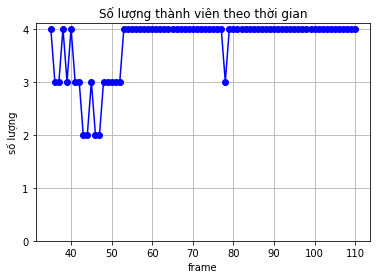

In [13]:
def get_number_curve():
    """Vẽ biểu đồ đường thể hiện số lượng thành viên ở mỗi frame"""
    emotions = ['ANGRY', 'FEAR', 'SAD', 'NEUTRAL', 'HAPPY', 'SURPRISED']
    curve = []
    for index, row in df.iterrows():
        num = 0
        for emotion in emotions:
            val = str(row[emotion])
            if val == 'nan':
                continue
            num += len(val)
        curve.append({'frame': row['FRAME'], 'number': num})
    return curve

def plot_number_curve(curve):
    frames = []
    numbers = []
    for point in curve:
        frames.append(point['frame'])
        numbers.append(point['number'])
    plt.plot(frames, numbers, color='blue', marker='o')
    plt.xlabel('frame')
    plt.ylabel('số lượng')
    plt.yticks(range(0,5,1))
    plt.title('Số lượng thành viên theo thời gian')
    plt.grid(True)
    plt.show()

plot_number_curve(get_number_curve())

##VẼ ĐƯỜNG CONG CẢM XÚC THEO THỜI GIAN

In [14]:
def get_one_curve(df, fr_label):
    """
    Hàm rút trích đường cong cảm xúc của một người từ dataframe 
    Input:
        df: dataframe
        fr_label: nhãn của người muốn rút trích cảm xúc
    Output:
        visualize_data: dữ liệu lưu giữ đường cong cảm xúc
    """
    
    emotions = ['ANGRY', 'FEAR', 'SAD', 'NEUTRAL', 'HAPPY', 'SURPRISED']
    fr_dict = {'JAMES': 'a', 'JISOO': 'b', 'JENNIE': 'c', 'ROSE': 'd', 'LISA': 'e'}
    fr_char = fr_dict[fr_label]
    visualize_data = {'fr_label': fr_label, 'curve': []}
    
    
    for index, row in df.iterrows():
        for emotion in emotions:
            s = str(row[emotion])
            if s == 'nan':
                continue
            if fr_char in s:
                visualize_df = {}
                visualize_df['frame']=row['FRAME']
                visualize_df['fer_label']=emotion
                visualize_data['curve'].append(visualize_df)
                break         
    return visualize_data

def get_all_curves():
    curves = []
    for member in ['JISOO', 'JENNIE', 'ROSE', 'LISA']:
        curves.append(get_one_curve(df, member))
    return curves


def plot_one_curve(frames, fer_labels, fr_label):
    plt.plot(frames, fer_labels, label=fr_label, color='red', marker='o')
    plt.xlabel('frame')
    plt.title('Đường cong cảm xúc ' + fr_label + ' theo thời gian')
    plt.grid(True)
    plt.show()


def plot_all_curves(curves):
    for curve in curves:
        points = curve['curve']
        frames = []
        fer_labels = []
        for p in points:
            frames.append(p['frame'])
            fer_labels.append(p['fer_label'])
        plot_one_curve(frames, fer_labels, curve['fr_label'])

def get_avg_curve():
    """Vẽ đường cong cảm xúc trung bình"""
    # Tính trung bình trạng thái cảm xúc của tất cả thành viên tại các frame
    # Ý tưởng: đặt số cho mỗi chỉ số cảm xúc, tính giá trị trung bình, lấy phần nguyên
    # Vẽ đường cong cảm xúc tương ứng
    avg_curve = {'fr_label': 'trung bình', 'curve': []}
    emotions = {'ANGRY': 0, 'FEAR': 1, 'SAD': 2, 'NEUTRAL': 3, 'HAPPY': 4, 'SURPRISED': 5} 
    emotion_list = list(emotions.keys())
    
    for index, row in df.iterrows():
        avg_score = 0
        num = 0
        for emotion in emotions:
            val = str(row[emotion])
            if val == 'nan':
                continue
            n = len(val)
            num += n
            avg_score += n*emotions[emotion]
        avg_score /= num
        avg_curve['curve'].append({'frame': row['FRAME'], 'fer_label': emotion_list[int(np.round(avg_score))]})
    return avg_curve

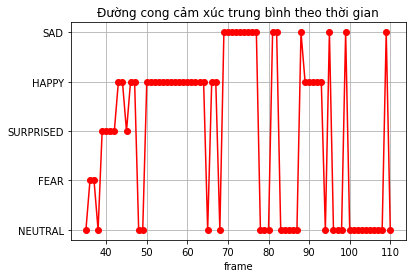

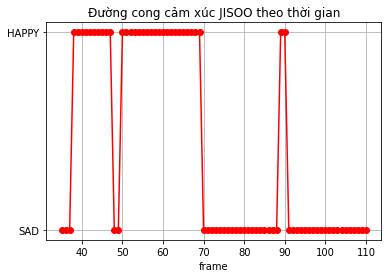

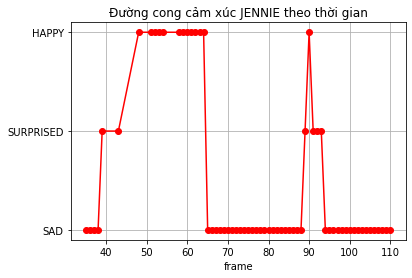

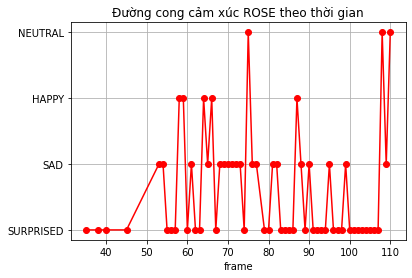

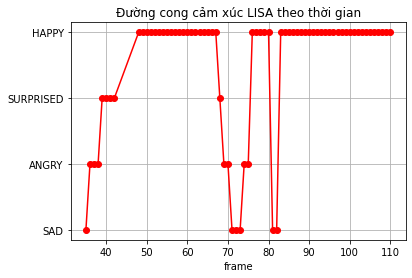

In [15]:
curves = get_all_curves()
curves.insert(0, get_avg_curve())
plot_all_curves(curves)